<a href="https://colab.research.google.com/github/kmayutrisna/IMDB/blob/main/IMDB_FastText%2BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.11.1-py3-none-any.whl (227 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199771 sha256=bf8a1b6ce9d4e17f9c2e33d1f348cc878fe67f755a2812f9a5404a654a7c7bd0
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [2]:
import fasttext
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM

In [3]:
#Get the dataset from gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Display top of data
data =pd.read_csv("drive/My Drive/data/IMDB Dataset.csv")

In [5]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [6]:
# Text preprocessing
from nltk.corpus import stopwords
def preprocess_text(text):

    # Text cleaning
    text = re.sub('[^a-zA-Z]', ' ', text)

    #Single character removal
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)

    #Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)

    # Lowercasing
    text = text.lower()

    # Lowercasing
    text = text.split()

    # Stopword removal
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if not word in stop_words]

    # Join the tokens back to a single string
    text = ' '.join(text)
    return text

In [7]:
# Preprocess the text column
data['review'] = data['review'].apply(preprocess_text)

In [8]:
# Preprocess the text data
texts = data['review'].values
labels = data['sentiment'].map({'positive': 1, 'negative': 0}).values

In [9]:
# Split the dataset into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [10]:
# Tokenize the text data
tokenizer = Tokenizer(num_words=10000)  # You can adjust 'num_words' based on your vocabulary size
tokenizer.fit_on_texts(train_data)

# Convert text to sequences and pad them
train_sequences = tokenizer.texts_to_sequences(train_data)
test_sequences = tokenizer.texts_to_sequences(test_data)

max_sequence_length = 300  # You can adjust this based on your dataset
train_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post', truncating='post')


In [11]:
# Download FastText pretrained embeddings
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!gunzip cc.en.300.vec.gz




--2023-09-19 08:45:16--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.19, 3.162.163.34, 3.162.163.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G   205MB/s    in 5.7s    

2023-09-19 08:45:22 (220 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]



In [12]:
# Load FastText embeddings
embedding_dim = 300  # This should match the dimension of the FastText embeddings you downloaded
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
fasttext_file = 'cc.en.300.vec'

with open(fasttext_file, encoding="utf8") as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        if word in tokenizer.word_index:
            embedding_matrix[tokenizer.word_index[word]] = np.asarray(values[1:], dtype='float32')

In [13]:
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_sequence_length,
                    trainable=False))  # Set trainable to False to keep FastText embeddings fixed

# Add a single LSTM layer
model.add(LSTM(64))  # You can adjust the number of units as needed

# Add a Dense layer for binary classification
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
batch_size = 128
epochs = 5

history = model.fit(train_sequences, train_labels, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/5
250/250 [==============================] - 102s 402ms/step - loss: 0.6954 - accuracy: 0.5044 - val_loss: 0.6927 - val_accuracy: 0.5081
Epoch 2/5
250/250 [==============================] - 100s 399ms/step - loss: 0.6925 - accuracy: 0.5077 - val_loss: 0.6922 - val_accuracy: 0.5011
Epoch 3/5
250/250 [==============================] - 112s 449ms/step - loss: 0.6958 - accuracy: 0.5049 - val_loss: 0.6930 - val_accuracy: 0.5009
Epoch 4/5
250/250 [==============================] - 103s 412ms/step - loss: 0.6929 - accuracy: 0.5014 - val_loss: 0.6935 - val_accuracy: 0.5001
Epoch 5/5
250/250 [==============================] - 102s 410ms/step - loss: 0.6927 - accuracy: 0.5061 - val_loss: 0.6928 - val_accuracy: 0.5004


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

# Assuming you already have predictions and test_labels
predictions = model.predict(test_sequences)
predictions = (predictions > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(test_labels, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Calculate precision, recall, and F1 score
precision = precision_score(test_labels, predictions)
recall = recall_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions)

print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

# Calculate Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(test_labels, predictions)
print(f"MCC Score: {mcc * 100:.2f}%")


313/313 [==============================] - 19s 61ms/step
Accuracy: 50.57%
Precision: 50.48%
Recall: 99.58%
F1 Score: 67.00%
MCC Score: 2.39%


In [16]:
from sklearn.metrics import classification_report, confusion_matrix

# Calculate and print classification report
report = classification_report(test_labels, predictions, target_names=['Negative', 'Positive'])
print("Classification Report:\n", report)

# Calculate and print confusion matrix
confusion = confusion_matrix(test_labels, predictions)
print("Confusion Matrix:\n", confusion)

Classification Report:
               precision    recall  f1-score   support

    Negative       0.65      0.01      0.02      4961
    Positive       0.50      1.00      0.67      5039

    accuracy                           0.51     10000
   macro avg       0.58      0.50      0.34     10000
weighted avg       0.58      0.51      0.35     10000

Confusion Matrix:
 [[  39 4922]
 [  21 5018]]


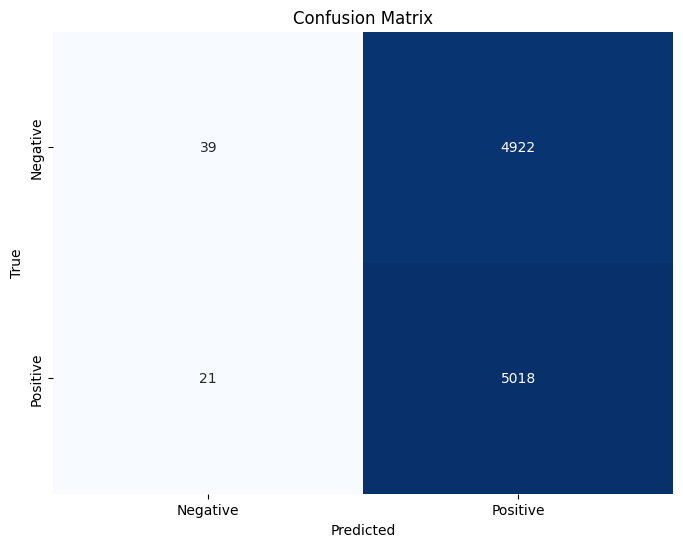

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
confusion = confusion_matrix(test_labels, predictions)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

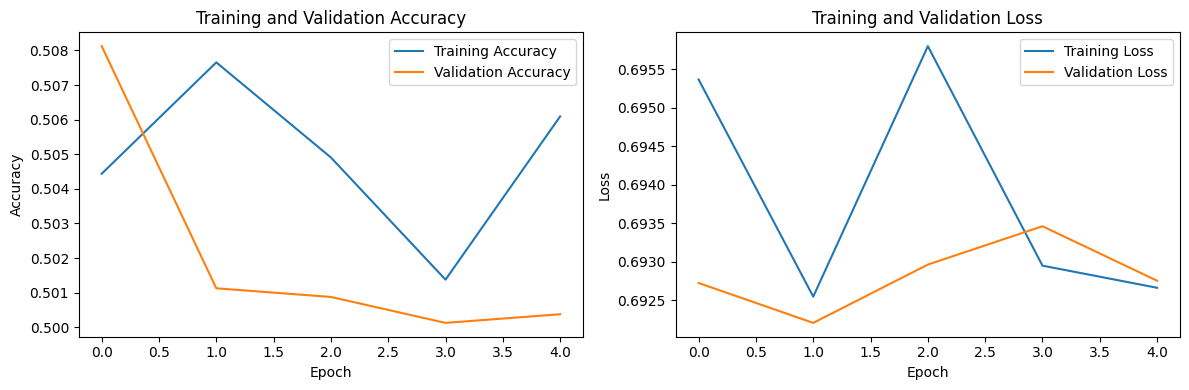

In [18]:
# Plot Training History (Accuracy and Loss)
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()
